In [155]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from datetime import datetime
import warnings
import sys
import os


In [157]:
with open('/Users/aiyan/Desktop/Project/marketing_campaign.csv') as f:
    lines = f.readlines()

# manually split lines
rows = [line.strip().split('\t') for line in lines]

# now create DataFrame
import pandas as pd
df = pd.DataFrame(rows[1:], columns=rows[0])
df.head(10)

,"""ID",Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,"Response"""
0,"""5524",1957,Graduation,Single,58138,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,"1"""
1,"""2174",1954,Graduation,Single,46344,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,"0"""
2,"""4141",1965,Graduation,Together,71613,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,"0"""
3,"""6182",1984,Graduation,Together,26646,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,"0"""
4,"""5324",1981,PhD,Married,58293,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,"0"""
5,"""7446",1967,Master,Together,62513,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,"0"""
6,"""965",1971,Graduation,Divorced,55635,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,"0"""
7,"""6177",1985,PhD,Married,33454,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,"0"""
8,"""4855",1974,PhD,Together,30351,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,"1"""
9,"""5899",1950,PhD,Together,5648,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,"0"""


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   "ID                  2240 non-null   object
 1   Year_Birth           2240 non-null   object
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2240 non-null   object
 5   Kidhome              2240 non-null   object
 6   Teenhome             2240 non-null   object
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   object
 9   MntWines             2240 non-null   object
 10  MntFruits            2240 non-null   object
 11  MntMeatProducts      2240 non-null   object
 12  MntFishProducts      2240 non-null   object
 13  MntSweetProducts     2240 non-null   object
 14  MntGoldProds         2240 non-null   object
 15  NumDealsPurchases    2240 non-null   object
 16  NumWeb

In [161]:
print(f'Dataset size: {df.shape}')

Dataset size: (2240, 29)


In [163]:
warnings.filterwarnings('ignore')

In [173]:
#FEATURE GENERATION
df['Age'] = datetime.now().year - df['Year_Birth']  # Client Age

In [175]:
def get_different_year():
    registration_year = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y').apply(lambda x: x.year)
    current_year = datetime.now().year
    return current_year - registration_year

df['Years_Since_Registration'] = get_different_year()  # Number of years since customer registration

In [181]:
df["Education"] = df["Education"].replace({"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 2, "PhD": 3})

In [189]:
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

step_2 = df['Marital_Status'].replace({'Alone': 1, 'Partner': 2})

df["Family_Size"] = step_2 + df['Kidhome'] + df['Teenhome']  # Total number of people in the family

df = pd.concat([df, pd.get_dummies(df['Marital_Status'])], axis=1)  # Separate features for Alone and Partner

In [199]:
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Sum_Mnt'] = df[mnt_cols].sum(axis=1)  # Total amount spent on products

In [205]:
accepted_cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Num_Accepted_Cmp'] = df[accepted_cmp_cols].astype(int).sum(axis=1)


In [207]:
total_purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Total_Purchases'] = df[total_purchases].sum(axis=1)  # Total number of purchases

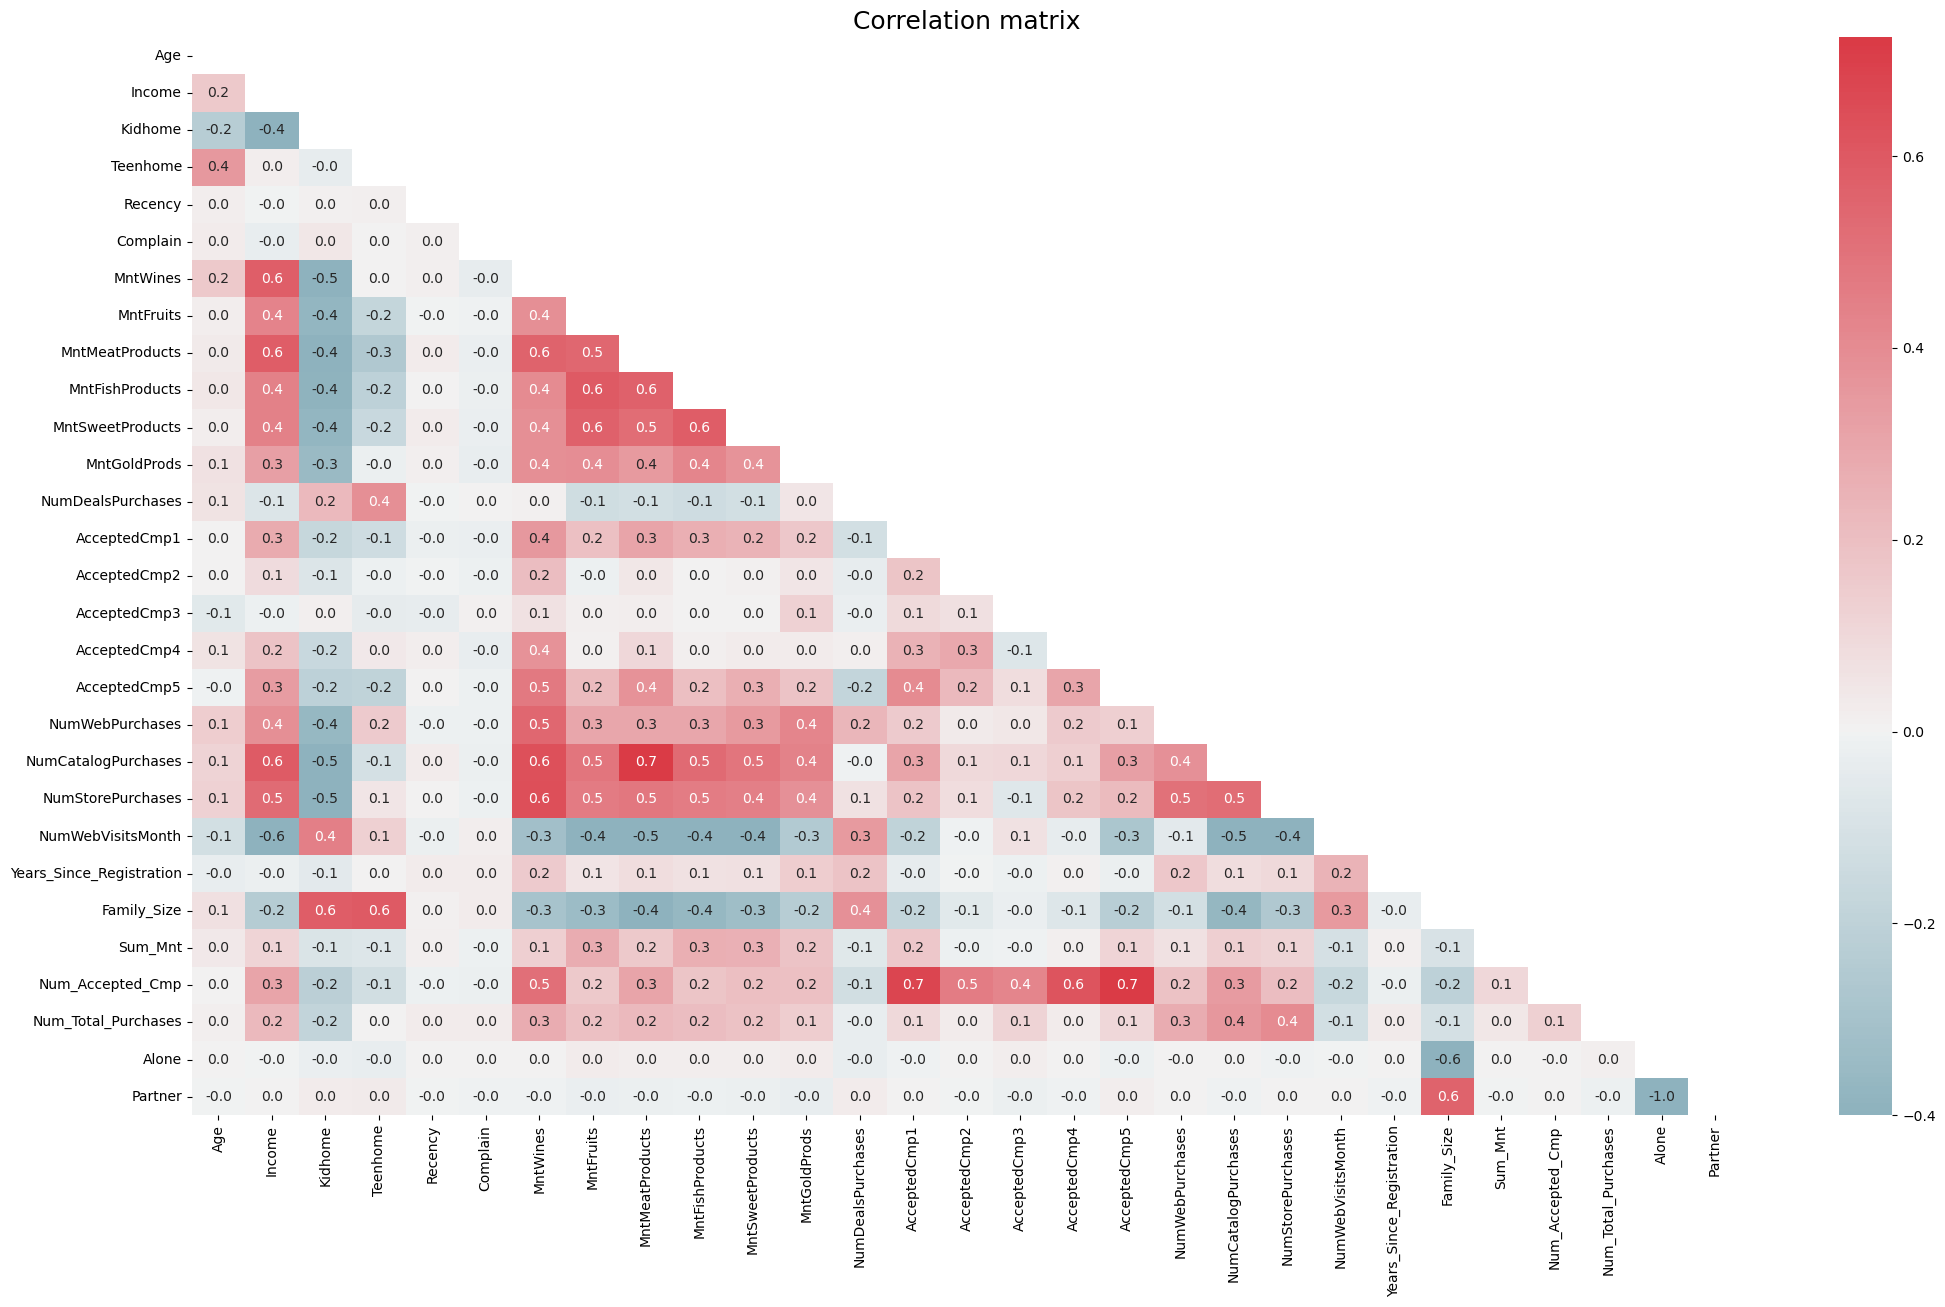

In [217]:
to_corr = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain', 
          'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
          'MntGoldProds', 'NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
          'AcceptedCmp4', 'AcceptedCmp5', 'NumWebPurchases', 'NumCatalogPurchases', 
          'NumStorePurchases', 'NumWebVisitsMonth', 'Years_Since_Registration', 'Family_Size',
           'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases', 'Alone', 'Partner']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)

plt.show()

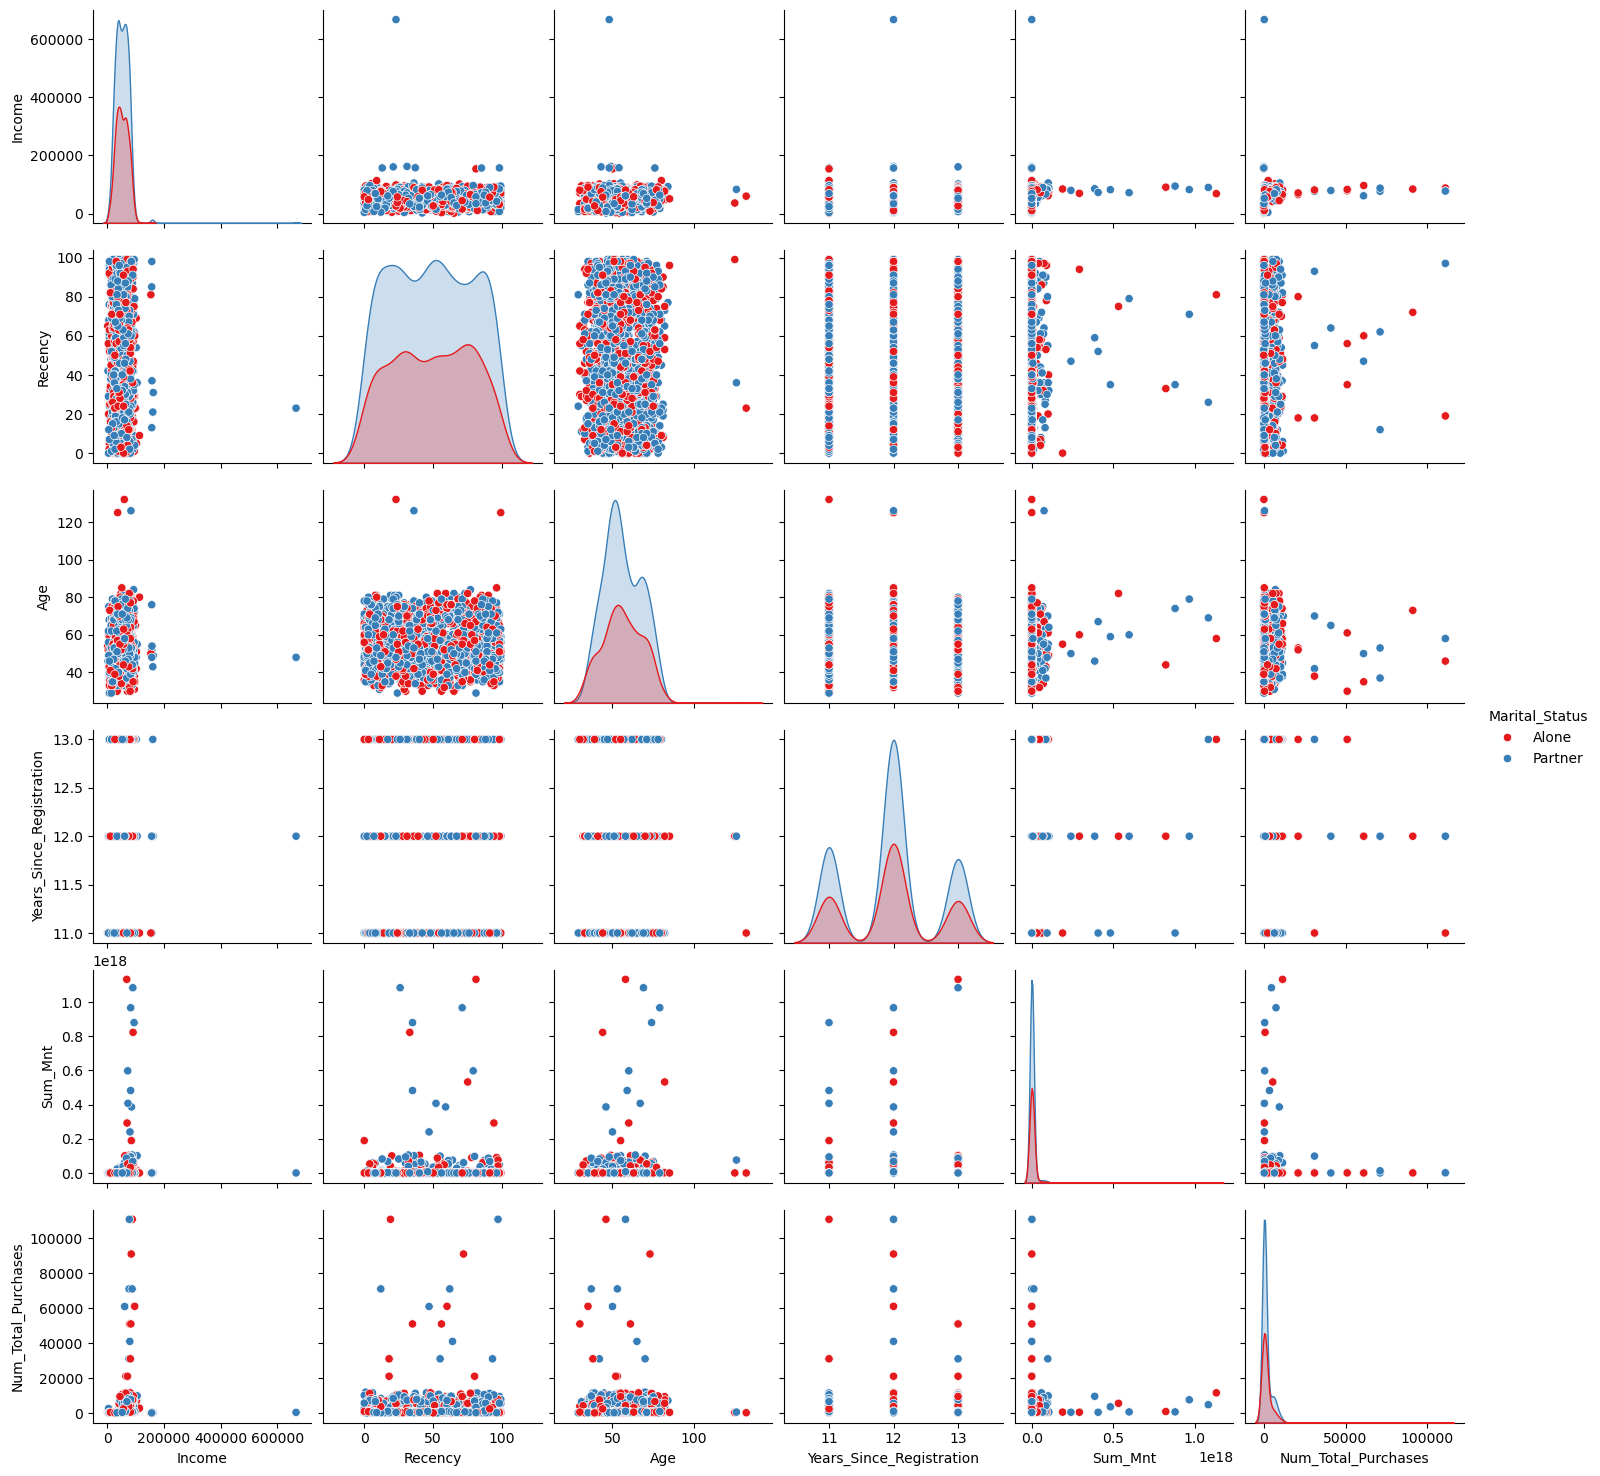

In [219]:
to_plot = ['Income', 'Recency', 'Age', 'Years_Since_Registration', 'Sum_Mnt',
           'Num_Total_Purchases', 'Marital_Status']
sns.pairplot(df[to_plot], hue='Marital_Status', palette='Set1')
plt.show()

In [225]:
#Data Cleaning
df.isna().sum()

"ID                          0
Year_Birth                   0
Education                    0
Marital_Status               0
Income                      24
Kidhome                      0
Teenhome                     0
Dt_Customer                  0
Recency                      0
MntWines                     0
MntFruits                    0
MntMeatProducts              0
MntFishProducts              0
MntSweetProducts             0
MntGoldProds                 0
NumDealsPurchases            0
NumWebPurchases              0
NumCatalogPurchases          0
NumStorePurchases            0
NumWebVisitsMonth            0
AcceptedCmp3                 0
AcceptedCmp4                 0
AcceptedCmp5                 0
AcceptedCmp1                 0
AcceptedCmp2                 0
Complain                     0
Z_CostContact                0
Z_Revenue                    0
Response"                    0
Age                          0
Years_Since_Registration     0
Family_Size                  0
Alone   

In [227]:
df.dropna(inplace=True)  # Removed objects with gaps in income

In [229]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

df = remove_outliers(df, 'Age')
df = remove_outliers(df, 'Income')

In [233]:
#remove unnecessary features
df.drop(['Year_Birth', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Marital_Status'], axis=1, inplace=True)

In [259]:
#Standardazing 
def scaling_func(df: pd.DataFrame) -> None:
    mms = MinMaxScaler()
    return pd.DataFrame(data=mms.fit_transform(df), columns=df.columns)


df_scaled = scaling_func(df)
df_scaled.index = df.index  # for convenient work with dataframe

In [257]:
for col in df.columns:
    if df[col].astype(str).str.contains('True|False').any():
        print(col, df[col].unique()[:5])


In [263]:
#reducing dimensionality
def dim_reduction(data: pd.DataFrame) -> pd.DataFrame:
    n_components = 8
    pca = PCA(n_components=n_components, random_state=42)
    data = pd.DataFrame(pca.fit_transform(data), columns =([f'PC{i}' for i in range(1, n_components + 1)]))
    return data

df_transform = dim_reduction(df_scaled)  # df: scaling + dimensionality reduction
df_transform.index = df_scaled.index  # for convenient work with dataframes

In [265]:
#clustering